Данный проект направлен на анализ финансовых магистратур во Франции. В нем мы посмотрим не только сами университеты и программы, но еще и проведем небольшой анализ городов, в которых расположены кампусы университетов. Для базовой таблицы были взяты данные с сайта mastersportal.com, в котором уже были заданы условия на программу: очное обучение, финансовая направленность, страна обучения - Франция. 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
response = requests.get('https://search.prtl.co/2023-02-23/?q=en-306|di-93|ci-10|lv-master|tc-EUR|uc-1|ur-38&size=30&start=0')
data = response.json()

In [3]:
unis = []

for i in range(len(data)):
  funcs = data[i]['card']['func']

  programme_name = funcs['getTitle']
  university_name = funcs['getUniversityLink']['func']['getDescription']
  location = funcs['getLocation']['func']['getCity']['func']['getDescription']
  fees = [fee['func']['getAmount'] for fee in funcs['getTuitionFees'] if fee['func']['getTarget'] == 'international'][0]
  duration = funcs['getDuration']['func']['getAmount']
  if location == "Chambéry": location = "Chambery"
  unis.append([programme_name, university_name, location, fees, duration])


In [4]:
df = pd.DataFrame(unis, columns = ['Programme', 'University', 'Location', 'Fees', 'Duration (months)'])
df = df[df['Location'] != 'Singapore'] 
#данное условие стоит тут не просто так, на самом деле, одна из программ реализуется на несколько городов, в то время как главные кампус 
#базируется в Сингапуре(по этой причине локация распознается как Сингапур), поэтому будем считать данную магистратуру не совсем 
#французской и исключим ее 



Тут мы начинаем рассматривать не столько саму программу, сколько город ее расположения. Для оценки города для начала мы выкачаем данные об уровне преступности в каждой зоне.

In [5]:
def get_crime_rate(city):
    url = f'https://www.numbeo.com/crime/in/{city}'

    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'lxml')

    table = soup.find('table', class_='table_indices')

    crime_types = []
    crime_indices = []

    for row in table.find_all('tr')[1:]:
        cells = row.find_all('td')
        crime_type = cells[0].text.strip()
        crime_index = cells[1].text.strip()
        crime_types.append(crime_type)
        crime_indices.append(crime_index)

    for crime_type, crime_index in zip(crime_types, crime_indices):
        if crime_type == "Crime Index:":
          return float(crime_index)

In [6]:
# в Numbeo Rouen называется Rouen-France
# по коммуне Jouy-en-Josas нет данных, она находится рядом с Версалем, поэтому возьмем данные оттуда
# то же самое с Chambery - населенный пункт рядом с Греноблем
substitutes_for_crime = {"Rouen": "Rouen-France", "Jouy-en-Josas": "Versailles-France", "Chambery": "Grenoble"} 

In [7]:
cities = df['Location'].unique().tolist()
crime_indecies = {city: 0 for city in cities}
for city in cities:
  if city in substitutes_for_crime.keys():
    crime_indecies[city] = get_crime_rate(substitutes_for_crime[city])
  else:
    crime_indecies[city] = get_crime_rate(city)

df['Crime level'] = df['Location'].map(crime_indecies)

In [8]:
# снова доступны не все города, поэтому города, отсутствующие на сайте заменим на ближайшие, например, Jouy-en-Josas - спутник Парижа
# поэтому мы можем спокойно делать такие замены  
substitutes_for_costs = {"Jouy-en-Josas": "Paris", "Chambery": "Grenoble", "Clermont-Ferrand": "Lyon"} 
cities = df['Location'].unique().tolist()

In [9]:
#теперь, помимо уровня преступности мы посмотрим еще и на стоимость жизни в городе
def get_cost_of_living(city):
  url = f'https://www.expatistan.com/cost-of-living/{city.lower()}'

  response = requests.get(url)

  soup = BeautifulSoup(response.text, 'html.parser')

  element = soup.find('div', class_='block')
  estimated_costs = element.find_all('li', class_='key-point')
  estimated_cost = estimated_costs[1].find('span', class_="price")
  return int(estimated_cost.text.replace("€", "").replace(",", ""))




In [10]:
living_cost = {city: 0 for city in cities}
for city in cities:
  if city in substitutes_for_costs.keys():
    living_cost[city] = get_cost_of_living(substitutes_for_costs[city])
  else:
    living_cost[city] = get_cost_of_living(city)

df['Cost of living per month'] = df['Location'].map(living_cost)

In [11]:
df['Total costs'] = (df['Fees'] / 12 + df['Cost of living per month']) * df['Duration (months)']
# в нашей изначальной табличке можно посмотреть на продолжительность программы в месяцах, поэтому с помощью данной новой колонки
# мы получим данные об общей сумме денег, которую скорее всего придется выложить за весь период обучения 

In [12]:
def extract_region_name(string):
    pattern = r'\bZone:\s*sa:\s*([^\.]+)'
    match = re.search(pattern, string)
    if match:
        return match.group(1).strip()
    else:
        return None

In [13]:
# и финальная колонка - безработица, данный показатель позволит будущему студенту принять решения о том, нужно ли оставаться в соответствующем
# городе после окончания обучения или нет 
def get_unemployment_data(page):
    url = f"https://www.ceicdata.com/en/france/unemployment-by-region-and-zone?page={page}"

    response = requests.get(url)

    soup = BeautifulSoup(response.content, "lxml")

    names = []
    values = []
    headers = soup.find_all("h3")
    for header in headers:
        names.append(extract_region_name(header.text))

    tables = soup.find_all("table")

    for table in tables:
        rows = table.find_all("tr")

        headers = [header.text.strip() for header in rows[0].find_all("th")]
        data = []
        for row in rows[1:]:
            row_data = [cell.text.strip() for cell in row.find_all("td")]
            data.append(row_data)

        values.append(list(data[0][0].split('\n'))[0])

    res = {names[i]: float(values[i]) for i in range(len(names))}
    return res

In [14]:
all_cities_data = {}
for i in range(1, 5):
  all_cities_data.update(get_unemployment_data(i))

In [15]:
substitutes_for_unemployment = {"Jouy-en-Josas": "Paris", "Chambery": "Grenoble"} 

In [16]:
city_to_unemployment = {}
for city in cities:
  if city not in substitutes_for_unemployment.keys():
    city_to_unemployment[city] = all_cities_data[city]
  else:
    city_to_unemployment[city] = all_cities_data[substitutes_for_unemployment[city]]

In [20]:
# выведем же, наконец-то, табличку 
df['Unemployment level'] = df['Location'].map(city_to_unemployment)
df

,Programme,University,Location,Fees,Duration (months),Crime level,Cost of living per month,Total costs,Unemployment level
0,"International Accounting, Audit and Control",IÉSEG School of Management,Paris,11666,18,57.09,3056,72507.0,8.3
1,Corporate Finance and Fintech,ESC Clermont Business School,Clermont-Ferrand,11950,12,47.86,1893,34666.0,8.1
2,Finance,Toulouse 1 Capitole University,Toulouse,3770,12,50.14,1720,24410.0,9.4
4,Corporate Finance,Toulouse 1 Capitole University,Toulouse,2500,12,50.14,1720,23140.0,9.4
5,QEM - Models and Methods of Quantitative Econo...,Panthéon-Sorbonne University,Paris,9000,24,57.09,3056,91344.0,8.3
6,"Master in Accounting, Finance and Management",HEC Paris,Jouy-en-Josas,36250,12,11.76,3056,72922.0,8.3
7,Advances in Finance and Accounting (AFA),"Grenoble INP, Graduate schools of Engineering ...",Grenoble,3862,12,58.53,1670,23902.0,7.8
8,Corporate Finance,NEOMA Business School,Rouen,14320,15,52.64,1396,38840.0,10.2
9,M2 Economics,Paris-Saclay University,Paris,243,12,57.09,3056,36915.0,8.3
10,"Accounting, Auditing and Management Control",Toulouse 1 Capitole University,Toulouse,3770,12,50.14,1720,24410.0,9.4


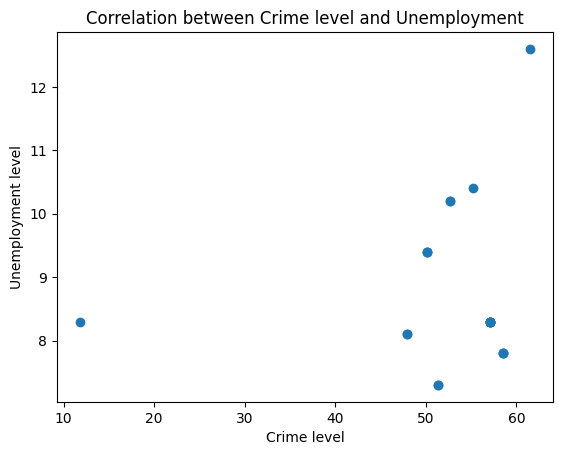

In [18]:
# теперь посмотрим на всякие графички, связанные с нашим проектом
# начнем с корреляции между уровнем преступности и безработицей в регионе 
df["Crime level"] = pd.to_numeric(df["Crime level"], errors="coerce")
df["Unemployment level"] = pd.to_numeric(df["Unemployment level"], errors="coerce")
df = df.dropna(subset=["Crime level", "Unemployment level"])
plt.scatter(df["Crime level"], df["Unemployment level"])
plt.xlabel("Crime level")
plt.ylabel("Unemployment level")
plt.title("Correlation between Crime level and Unemployment")
plt.show()

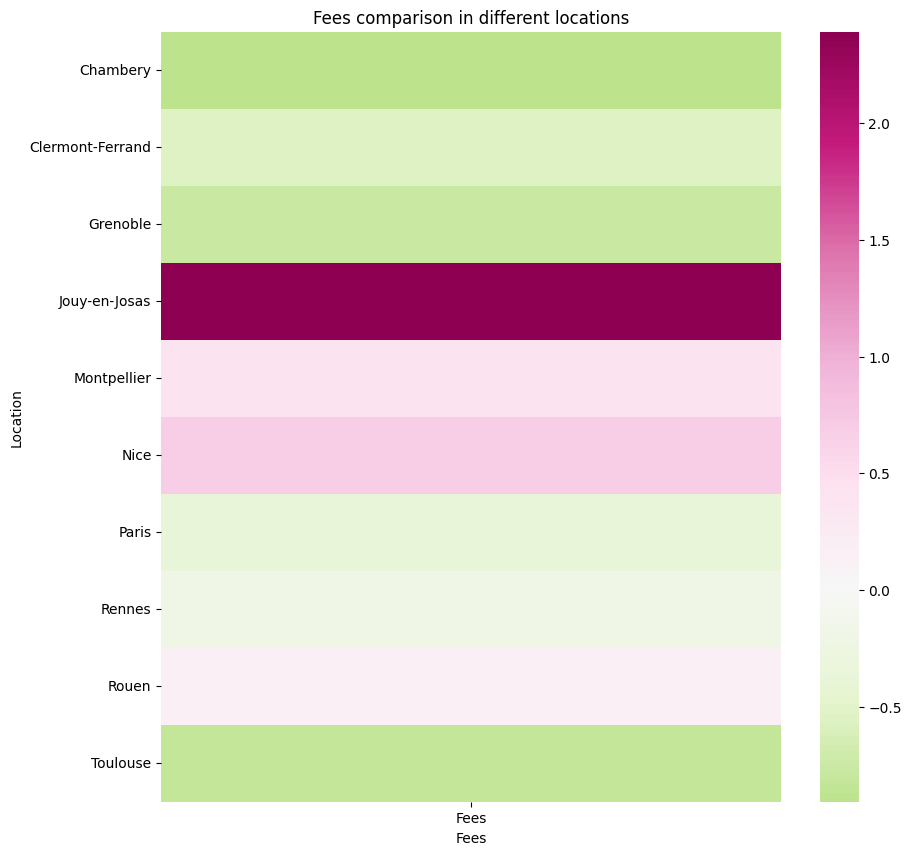

In [19]:
# теперь посравниваем то, сколько придется выложить за только само обучение 
# видим, что выигрывает Jouy-en-Josas со своим HEC, в целом, неудивительно) 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
df_location_fees = df[['Location', 'Fees']]
df_location_fees['Fees'] = pd.to_numeric(df_location_fees['Fees'], errors='coerce')
df_location_fees.dropna(subset=['Fees'], inplace=True)
pivot_table = df_location_fees.pivot_table(index='Location', values='Fees', aggfunc='mean')
df_normalized = (pivot_table - pivot_table.mean()) / pivot_table.std()
plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(data=df_normalized,
                      cmap='PiYG_r',
                      center=0)
plt.title('Fees comparison in different locations')
plt.xlabel('Fees')
plt.ylabel('Location')
plt.show()


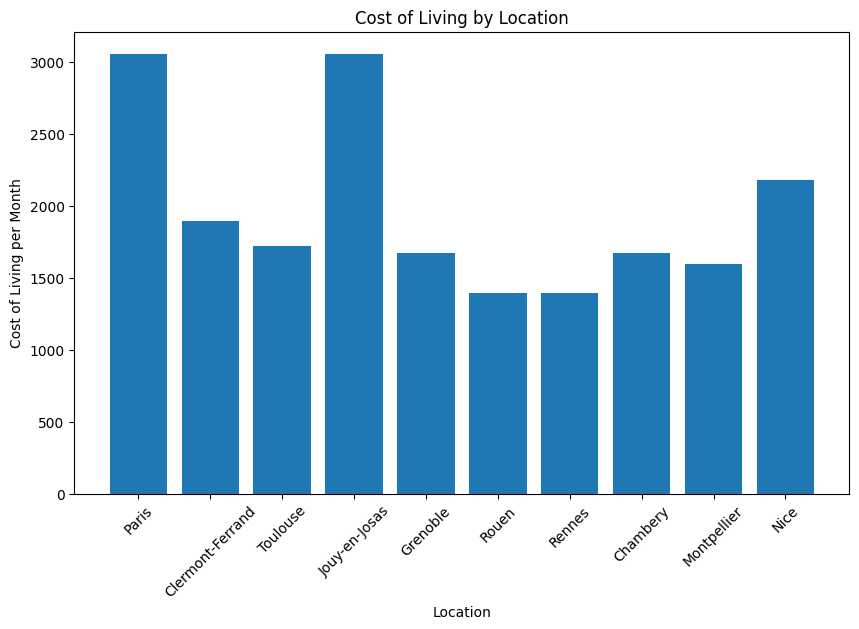

In [26]:
df_unique_locations = df.drop_duplicates(subset='Location')

plt.figure(figsize=(10, 6))
plt.bar(df_unique_locations['Location'], df_unique_locations['Cost of living per month'])
plt.xlabel('Location')
plt.ylabel('Cost of Living per Month')
plt.title('Cost of Living by Location')
plt.xticks(rotation=45)
plt.show()
# в данном случае мы вывели bar chart, в котором отобразили стоимость жизни в зависимости от локации, при этом учли, что в таблице некоторые 
# города повторяются, поэтому если город повторялся более одного раза, то выводилось его первое повторение 